In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from functools import partial, reduce
from operator import mul
sns.set()

In [2]:
y_history_points = [1.7777, 4.5634, 13.8436, 37.3387, 72.3593]
x_history_points = [1.3, 2.1, 3.7, 6.1, 8.5]
x = 4.5
actual_func = lambda x: 1/x*math.log10(x)+x**2

# Lagrange interpolation

In [3]:
class LagrangeInterpolation:
    def __init__(self, x_history_points, y_history_points):
        self.x_history_points = x_history_points
        self.y_history_points = y_history_points
        self.interpolated_func = self.__interpolate_func()
        
    def __interpolate_func(self):
        # building a nested function which is a composite of other functions
        list_to_sum_up = []
        for i in range(len(self.y_history_points)):
            funcs = []
            for j in range(len(self.y_history_points)):
                if i!=j:
                    func = lambda x, x_j, x_i: (x-x_j)/(x_i-x_j)
                    func = partial(func, x_j=self.x_history_points[j], x_i=self.x_history_points[i])
                    funcs.append(func)
            L = lambda x, y_i, funcs: y_i*reduce(mul,[func(x=x) for func in funcs])    
            L = partial(L, y_i=self.y_history_points[i], funcs=funcs)
            list_to_sum_up.append(L)
        interpolated_func = lambda x: sum([func(x=x) for func in list_to_sum_up])
        return interpolated_func
    
    def interpolate(self, x):
        # inteprolation for single point
        return self.interpolated_func(x)
    
    def get_interpolated_curve(self):
        # interpolation for whole curve
        y_interpolated = [self.interpolated_func(i) for i in self.x_history_points]
        return self.x_history_points, y_interpolated
    
    def get_initial_curve(self):
        # getting intial curve
        return self.x_history_points, self.y_history_points
    
    def error_in_point(self, initial_func, x):
        # calculating error in point
        return abs(initial_func(x)-self.interpolated_func(x))

In [4]:
interpolation_cls = LagrangeInterpolation(x_history_points, y_history_points)

In [5]:
print(f'Interpolated value for x={x} is y={interpolation_cls.interpolate(x)}')

Interpolated value for x=4.5 is y=20.386783333333334


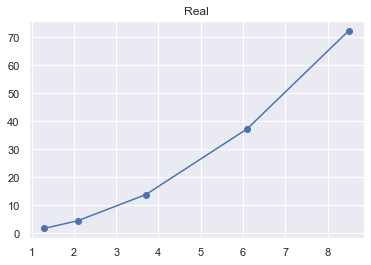

In [6]:
plt.plot(*interpolation_cls.get_initial_curve(), '-o', color='b');
plt.title('Real');

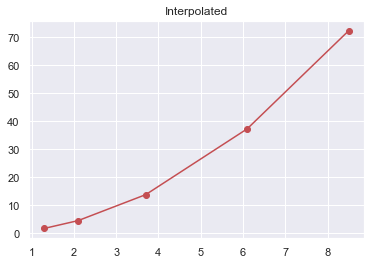

In [7]:
plt.plot(*interpolation_cls.get_interpolated_curve(), '-o', color='r')
plt.title('Interpolated');

In [8]:
print(f'Actual error : {interpolation_cls.error_in_point(actual_func, x)}')

Actual error : 0.008375003061185993


# Computing theoretical error

In [136]:
A = reduce(mul,[abs(x-i) for i in x_history_points])

In [137]:
A

39.32159999999998

In [138]:
n = len(x_history_points)-1
print(n)
B = reduce(mul,range(1,n+2))

4


In [139]:
B

120

In [140]:
K = A/B

In [141]:
K

0.32767999999999986

In [148]:
f = lambda x: 2*math.log(10)*(3*(math.log(x)**4)+5*(math.log(x)**3)-15*(math.log(x)**2)-60*math.log(x)-60)/(x**4*(math.log(x)**6))
# second derivative

In [149]:
M = lambda f: max([abs(f(i)) for i in x_history_points])

In [150]:
print("Theoretical error : {}".format(K*M(f)))

Theoretical error : 124199.2095887773
